In [4]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from scipy.ndimage import gaussian_filter
from joblib import Parallel, delayed

from scipy.stats import binned_statistic

# from numba import njit

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [5]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=None, fields=None, basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [6]:
sn = read_snap(700, 1)
center = np.array([0., 0., 0.])

In [39]:
def measure_halo_radial_profile(sn):
    center = sn.part1.pos.value[np.argmin(sn.part1.pot)]
    
    pos = sn.part1.pos.value - center
    
    r = np.linalg.norm(pos, axis=1)
    mass = np.full(sn.NumPart_Total[1], sn.MassTable[1])
    bins = np.logspace(-1, 1, 16)
    
    tot_mass, bin_edges, bin_idx = binned_statistic(r, mass, bins=bins, statistic='sum')
    
    rmean = np.zeros(len(tot_mass))
    
    for i in range(len(bin_edges)-1):
        vol = (4.*np.pi/3.) * (bin_edges[i+1]**3 - bin_edges[i]**3)
        tot_mass[i] /= vol
    
        rmean[i] = np.mean(r[bin_idx==i+1])
        
#         print(i, rmean[i], len(np.where(bin_idx==i+1)[0]))

    return rmean, tot_mass
    

In [40]:
snN0 = read_snap(0, 0, parttype=1)
snN = read_snap(500, 0, parttype=1)
snNl = read_snap(1000, 0, parttype=1)

In [41]:
snS = read_snap(300, 1, parttype=1)

In [42]:
rmeanN0, rhoN0 = measure_halo_radial_profile(snN0)

rmeanN, rhoN = measure_halo_radial_profile(snN)
rmeanNl, rhoNl = measure_halo_radial_profile(snNl)
rmeanS, rhoS = measure_halo_radial_profile(snS)

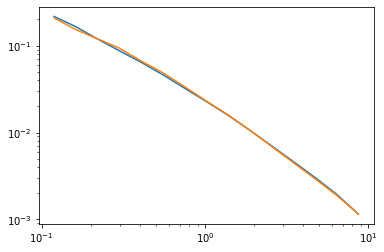

In [43]:
# plt.plot(rmeanN0, rhoN0)
plt.plot(rmeanN, rhoN)
# plt.plot(rmeanS, rhoS)
plt.plot(rmeanNl, rhoNl)

plt.xscale('log')
plt.yscale('log')

plt.show()

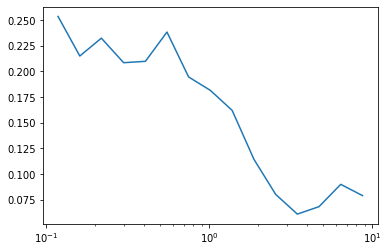

In [44]:
plt.plot(rmeanN0, (rhoN-rhoN0)/rhoN0)

plt.xscale('log')
plt.show()

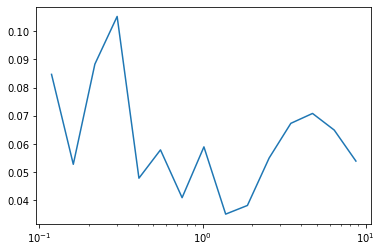

In [45]:
plt.plot(rmeanN0, (rhoS-rhoN)/rhoN)

plt.xscale('log')
plt.show()

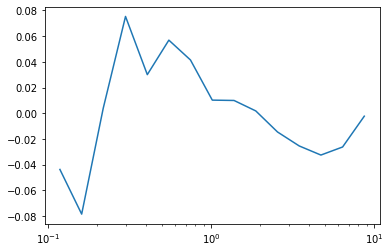

In [46]:
plt.plot(rmeanN0, (rhoNl-rhoN)/rhoN)

plt.xscale('log')
plt.show()